In [24]:
elastic_rods_dir = '../../../../elastic_rods/python/'
weaving_dir = '../../../'
import os
import os.path as osp
import sys; sys.path.append(elastic_rods_dir); sys.path.append(weaving_dir)
import numpy as np, elastic_rods, linkage_vis
import numpy.linalg as la
from bending_validation import suppress_stdout as so
import matplotlib.pyplot as plt
from elastic_rods import EnergyType, InterleavingType

# weaving
import analysis_helper, ribbon_linkage_helper, mesh_vis, linkage_utils, compute_curve_from_curvature, pipeline_helper, importlib
importlib.reload(analysis_helper)
importlib.reload(ribbon_linkage_helper)
importlib.reload(mesh_vis)
importlib.reload(linkage_utils)
importlib.reload(compute_curve_from_curvature)
importlib.reload(pipeline_helper)
from analysis_helper import (compare_turning_angle,
                            is_on_sphere, 
                            get_distance_to_center_scalar_field, 
                            plot_curvatures, 
                            get_curvature_scalar_field,
                            construct_elastic_rod_loop_from_rod_segments, 
                            concatenate_rod_properties_from_rod_segments, 
                            compute_min_distance_rigid_transformation)
from ribbon_linkage_helper import (update_rest_curvature, 
                                   set_ribbon_linkage,
                                   export_linkage_geometry_to_obj,
                                   write_linkage_ribbon_output_florin,
                                   write_distance_to_linkage_mesh)

from compute_curve_from_curvature import (match_geo_curvature_and_edge_len, get_all_curve_pattern)
from linkage_utils import order_segments_by_ribbons, get_turning_angle_and_length_from_ordered_rods

from pipeline_helper import (initialize_linkage, get_normal_deviation, set_joint_vector_field, stage_1_optimization, initialize_stage_2_optimizer, stage_2_optimization, InputOrganizer, write_all_output, set_surface_view_options, get_structure_analysis_view, get_max_distance_to_target_surface, contact_optimization, show_selected_joints, highlight_rod_and_joint)

import vis.fields
import matplotlib.cm as cm
import time

In [4]:
import parallelism
parallelism.set_max_num_tbb_threads(12)
parallelism.set_hessian_assembly_num_threads(4)
parallelism.set_gradient_assembly_num_threads(4)

In [5]:
scale = 1
rod_length = 0.07244622391567243 * scale
width = rod_length / 20 * 10 
thickness = width / 10 * 0.35 
print(width, thickness)
io = InputOrganizer('kleinbottle_projected_{}'.format(scale), thickness, width, weaving_dir)

0.036223111957836215 0.0012678089185242675


In [6]:
import py_newton_optimizer
OPTS = py_newton_optimizer.NewtonOptimizerOptions()
OPTS.gradTol = 1e-6
OPTS.verbose = 1;
OPTS.beta = 1e-8
OPTS.niter = 200
OPTS.verboseNonPosDef = False
rw = 1
sw = 10
drw = 0.01
dsw = 0.01

In [7]:
rw = 0.1
sw = 0.1

In [8]:
# vf = show_selected_joints(curved_linkage, [30, 205, 91, 303, 525, 462, 496, 152, 425, 254, 391, 348, 151, 255, 255, 349, 349, 31, 92, 461, 92, 461, 151])
# curved_linkage_view.update(vectorField = vf)

In [9]:
with so(): curved_linkage = initialize_linkage(surface_path = io.SURFACE_PATH, useCenterline = True, model_path = io.MODEL_PATH, cross_section = io.RIBBON_CS, subdivision_res = io.SUBDIVISION_RESOLUTION, interleaving_type=InterleavingType.weaving, use_constant_width = False, width_scale = [0.5, 1.5])
curved_linkage.set_design_parameter_config(use_restLen = True, use_restKappa = True)
curved_save_tgt_joint_pos = curved_linkage.jointPositions();
curved_linkage_view = linkage_vis.LinkageViewerWithSurface(curved_linkage, io.SURFACE_PATH)
set_surface_view_options(curved_linkage_view)
curved_linkage_view.show()

Renderer(camera=PerspectiveCamera(children=(PointLight(color='#999999', position=(0.0, 0.0, 5.0), quaternion=(…

In [10]:
curved_linkage.attraction_weight = 0.5

In [11]:
def normalize(vec):
    return vec / la.norm(vec)

In [12]:
def set_design_parameters_from_topology(curved_linkage):
    # Get rest length.
    segment_rest_length = []
    for i in range(curved_linkage.numSegments()):
        rod = curved_linkage.segment(i).rod
        pts = curved_linkage.get_closest_point_for_visualization(np.array(rod.deformedPoints()).flatten())
        pts = np.reshape(pts, (int(len(pts)/3), 3))
        rls = np.array([la.norm(pts[i+1] - pts[i]) for i in range(len(rod.deformedPoints())-1)])
        curved_linkage.segment(i).rod.setRestLengths(rls)
    #     because the segment rest length only include from joint to joint (so half of the first and last edge length is not considered in the segment length)
        segment_rest_length.append(sum(rls) - 0.5 * (rls[0] + rls[-1]))
    curved_linkage.setPerSegmentRestLength(segment_rest_length)
    # Get rest kappa.
    for i in range(curved_linkage.numSegments()):
        print('curvature ', i)
        rod = curved_linkage.segment(i).rod
        pts = curved_linkage.get_closest_point_for_visualization(np.array(rod.deformedPoints()).flatten())
        pts = np.reshape(pts, (int(len(pts)/3), 3))

        normals = np.array([curved_linkage.get_closest_point_normal(pt) for pt in pts])
        # Flip normal by directors.
        dc = rod.deformedConfiguration()
        directors = []
        directors.append(dc.materialFrame[0].d2)
        directors.extend([normalize(dc.materialFrame[edge_index - 1].d2 + dc.materialFrame[edge_index].d2) for edge_index in range(io.SUBDIVISION_RESOLUTION)[1:]])
        directors.append(dc.materialFrame[-1].d2)
        normals = np.array([normals[i] if np.dot(normals[i], directors[i]) > 0 else normals[i] * -1 for i in range(len(normals))])
        edges = np.array([pts[i+1] - pts[i] for i in range(len(pts)-1)])

        def get_rest_kappa(e1, e2, pn):
            cb = 2 * np.cross(e1, e2) / (la.norm(e1) * la.norm(e2) + np.dot(e1, e2))
            return np.dot(cb, pn)
        
        kappas = np.array([get_rest_kappa(edges[i], edges[i+1], normals[i+1]) for i in range(len(edges) - 1)])
        current_rk = rod.restKappas()

        for j in range(len(current_rk) - 2):
            current_rk[j+1][0] = kappas[j]
        curved_linkage.segment(i).rod.setRestKappas(current_rk)

In [13]:
set_design_parameters_from_topology(curved_linkage)

curvature  0
curvature  1
curvature  2
curvature  3
curvature  4
curvature  5
curvature  6
curvature  7
curvature  8
curvature  9
curvature  10
curvature  11
curvature  12
curvature  13
curvature  14
curvature  15
curvature  16
curvature  17
curvature  18
curvature  19
curvature  20
curvature  21
curvature  22
curvature  23
curvature  24
curvature  25
curvature  26
curvature  27
curvature  28
curvature  29
curvature  30
curvature  31
curvature  32
curvature  33
curvature  34
curvature  35
curvature  36
curvature  37
curvature  38
curvature  39
curvature  40
curvature  41
curvature  42
curvature  43
curvature  44
curvature  45
curvature  46
curvature  47
curvature  48
curvature  49
curvature  50
curvature  51
curvature  52
curvature  53
curvature  54
curvature  55
curvature  56
curvature  57
curvature  58
curvature  59
curvature  60
curvature  61
curvature  62
curvature  63
curvature  64
curvature  65
curvature  66
curvature  67
curvature  68
curvature  69
curvature  70
curvature  71
cu

In [14]:
def eqm_callback(prob, i):
    curved_linkage_view.update()

In [15]:
elastic_rods.compute_equilibrium(curved_linkage, callback = eqm_callback, options = OPTS)

0	0.00471712	1.86497	1.86497	1	1
1	0.000974611	0.227841	0.227841	1	1
2	0.000598017	0.082255	0.082255	1	1
3	0.000421827	0.0418462	0.0418462	1	1
4	0.000316992	0.0219675	0.0219675	1	1
5	0.000249921	0.0118611	0.0118611	1	1
6	0.000203905	0.00727985	0.00727985	1	1
7	0.000190356	0.00606667	0.00606667	1	1
8	0.000172936	0.00542193	0.00542193	1	1
9	0.000151181	0.00513734	0.00513734	1	1
10	0.000126173	0.00501371	0.00501371	1	1
11	0.000103302	0.00521009	0.00521009	1	1
12	9.64196e-05	0.00271642	0.00271642	1	1
13	8.71511e-05	0.00230472	0.00230472	1	1
14	7.56187e-05	0.00250994	0.00250994	1	1
15	6.2469e-05	0.00348408	0.00348408	1	1
16	4.75055e-05	0.00466356	0.00466356	1	1
17	4.55392e-05	0.00110213	0.00110213	1	1
18	4.28348e-05	0.000540091	0.000540091	1	1
19	3.86554e-05	0.000694196	0.000694196	1	1
20	3.35913e-05	0.00130154	0.00130154	1	1
21	2.88085e-05	0.00178182	0.00178182	1	1
22	2.46859e-05	0.00200025	0.00200025	1	1
23	2.14726e-05	0.001934	0.001934	1	1
24	1.91813e-05	0.00201083	0.00201083	1	1
25	1.89

Coefficient of Friction Percentiles 50, 75, 90:  1.6381370702156512 3.9697609319464884 7.13343558319645


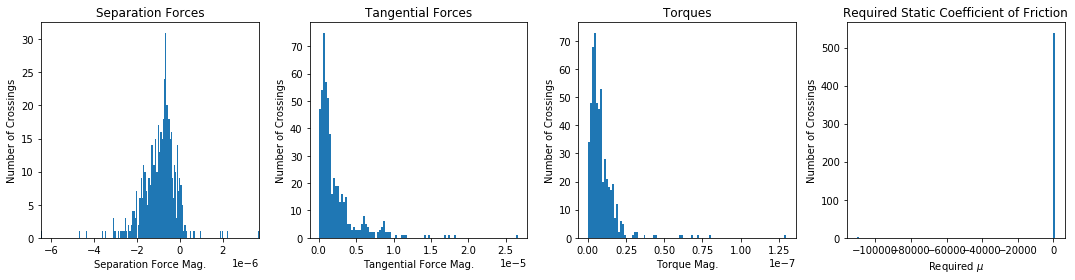

In [16]:
structure_view = get_structure_analysis_view(curved_linkage)
structure_view.show()

In [20]:
renderCam = curved_linkage_view.getCameraParams()

In [21]:
np.save('kleinbottle_renderCam.npy', renderCam)

In [22]:
def renderToFile(view, renderCam, path):
    orender = view.offscreenRenderer(width=2048, height=2048)
    orender.setCameraParams(renderCam)
    orender.render()
    orender.save(path)

In [25]:
distance_color = write_distance_to_linkage_mesh(curved_linkage, max(io.RIBBON_CS), None, return_distance_field = True)
curved_linkage_view.update(scalarField = distance_color[:, :3])
renderToFile(curved_linkage_view, renderCam, 'manual_kleinbottle.png')